## **Bibliotecas**

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import glob
import geopandas as gpd
import unicodedata
import re
import random
import requests

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## **Importação dos dados**

In [2]:
# Carregamento das bases de dados para o Pandas
#path_combs = r'C:\Users\Colaborador\Desktop\TCC\Datasets'
#path_dolar = r'C:\Users\Colaborador\Desktop\TCC\USD_BRLdata.csv'

path_combs = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Datasets'
path_dolar = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\USD_BRLdata.csv'

### PREÇOS DE COMBUSTÍVEIS

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=';') for file in files]
df_combs = pd.concat(many_dfs, ignore_index=False)

### COTAÇÃO DO DÓLAR

df_dolar = pd.read_csv(path_dolar, sep=',')

In [3]:
display(df_combs.head())
display(df_dolar.head())

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,NaN,PLANALTO,57308-000,GASOLINA,01/01/2024,"5,68",NaN,R$ / litro,VIBRA
1,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,NaN,PLANALTO,57308-000,GASOLINA ADITIVADA,01/01/2024,"5,68",NaN,R$ / litro,VIBRA
2,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,NaN,PLANALTO,57308-000,ETANOL,01/01/2024,"3,99",NaN,R$ / litro,VIBRA
3,NE,AL,ARAPIRACA,AUTO POSTO SAO FRANCISCO LTDA,12.706.529/0001-04,RUA SAO FRANCISCO,274,NaN,CENTRO,57300-080,GASOLINA,01/01/2024,"5,48",NaN,R$ / litro,VIBRA
4,NE,AL,ARAPIRACA,IBN PINTO E SILVA & CIA LTDA,01.242.690/0001-58,RODOVIA AL-110,678,KM 70,CANAFISTULA,57302-802,GASOLINA,01/01/2024,"5,69",NaN,R$ / litro,BRANCA


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.05.2024,"5,2443","5,1997","5,2587","5,1930",NaN,"0,79%"
1,30.05.2024,"5,2034","5,2038","5,2038","5,2036",NaN,"0,03%"
2,29.05.2024,"5,2018","5,1615","5,2141","5,1573",NaN,"0,79%"
3,28.05.2024,"5,1611","5,1715","5,1738","5,1349",NaN,"-0,19%"
4,27.05.2024,"5,1708","5,1713","5,1852","5,1557",NaN,"0,09%"


## **Informações gerais acerca dos dados**

In [4]:
# Informações gerais acerca dos dados
print(f"Dados sobre combustíveis:\nQuantidade de linhas: {df_combs.shape[0]}\nQuantidade de colunas: {df_combs.shape[1]}\n")
display(df_combs.dtypes)
print('------'*10)
print(f"Dados sobre cotação do Dólar (USD):\nQuantidade de linhas: {df_dolar.shape[0]}\nQuantidade de colunas: {df_dolar.shape[1]}\n")
display(df_dolar.dtypes)

Dados sobre combustíveis:
Quantidade de linhas: 2083811
Quantidade de colunas: 16



Regiao - Sigla        object
Estado - Sigla        object
Municipio             object
Revenda               object
CNPJ da Revenda       object
Nome da Rua           object
Numero Rua            object
Complemento           object
Bairro                object
Cep                   object
Produto               object
Data da Coleta        object
Valor de Venda        object
Valor de Compra      float64
Unidade de Medida     object
Bandeira              object
dtype: object

------------------------------------------------------------
Dados sobre cotação do Dólar (USD):
Quantidade de linhas: 625
Quantidade de colunas: 7



Data        object
Último      object
Abertura    object
Máxima      object
Mínima      object
Vol.        object
Var%        object
dtype: object

In [5]:
print("Quantidade de valores nulos em cada coluna - Dataset COMBUSTÍVEIS:")
display(df_combs.isnull().sum())
print('------'*10)
print("Quantidade de valores nulos em cada coluna - Dataset DÓLAR:")
display(df_dolar.isnull().sum())


Quantidade de valores nulos em cada coluna - Dataset COMBUSTÍVEIS:


Regiao - Sigla             0
Estado - Sigla             0
Municipio                  0
Revenda                    0
CNPJ da Revenda            0
Nome da Rua                0
Numero Rua               686
Complemento          1618721
Bairro                  4549
Cep                        0
Produto                    0
Data da Coleta             0
Valor de Venda             0
Valor de Compra      2083811
Unidade de Medida          0
Bandeira                   0
dtype: int64

------------------------------------------------------------
Quantidade de valores nulos em cada coluna - Dataset DÓLAR:


Data          0
Último        0
Abertura      0
Máxima        0
Mínima        0
Vol.        353
Var%          0
dtype: int64

## **Pré-processamento e tratamento dos dados**

In [6]:
# Filtrando pelos casos apenas de MG e eliminando os casos que não são Gasolina/Etanol
c1 = df_combs['Estado - Sigla'] == 'MG'
c2 = df_combs['Produto'] == 'GASOLINA'
c3 = df_combs['Produto'] == 'ETANOL'
df_fuels = df_combs[c1 & (c2 | c3)]

In [7]:
# Remoção de colunas indesejadas e mudança nos nomes das restantes - Dataset COMBUSTÍVEIS
non_relevant = ['Regiao - Sigla', 'Revenda', 'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro', 'Valor de Compra', 'Unidade de Medida']
new_name = {'Estado - Sigla': 'estado',
            'Municipio': 'municipio',
            'Cep': 'cep',
            'Produto' : 'tipo_comb',
            'Data da Coleta' : 'data',
            'Valor de Venda' : 'preco',
            'Bandeira' : 'bandeira'}
df_fuels = df_fuels.rename(columns=new_name)\
     .drop(non_relevant, axis=1)

# Remoção de colunas indesejadas e mudança nos nomes das restantes - Dataset DÓLAR
non_relevant = ['Abertura', 'Mínima', 'Vol.', 'Máxima']
new_name = {'Data': 'data',
            'Último': 'ultimo_dolar',
            'Var%': 'variacao_dolar'}
df_dolar = df_dolar.rename(columns=new_name)\
     .drop(non_relevant, axis=1)

In [8]:
print(f"Quantidade de linhas do Dataframe: {df_fuels.shape[0]}\nQuantidade de colunas do Dataframe: {df_fuels.shape[1]}\n---- Dataframe COMBUSTÍVEL ----")
display(df_fuels.dtypes)
print("---- Dataframe DÓLAR ----")
display(df_dolar.dtypes)

Quantidade de linhas do Dataframe: 118206
Quantidade de colunas do Dataframe: 7
---- Dataframe COMBUSTÍVEL ----


estado       object
municipio    object
cep          object
tipo_comb    object
data         object
preco        object
bandeira     object
dtype: object

---- Dataframe DÓLAR ----


data              object
ultimo_dolar      object
variacao_dolar    object
dtype: object

In [9]:
# Conversão de tipagem dos dados das colunas - Dataset COMBUSTÍVEIS
cvcols = ['estado', 'municipio', 'cep', 'tipo_comb', 'bandeira']
df_fuels[cvcols] = df_fuels[cvcols].astype("string")
df_fuels['preco'] = df_fuels['preco'].str.replace(',', '.').astype("float")
df_fuels['data'] = pd.to_datetime(df_fuels['data'], format='%d/%m/%Y')
df_fuels['cep'] = df_fuels['cep'].str.replace('-', '')

# Conversão de tipagem dos dados das colunas - Dataset COMBUSTÍVEIS

df_dolar['ultimo_dolar'] = df_dolar['ultimo_dolar'].str.replace(',', '.').astype("float")
df_dolar['variacao_dolar'] = df_dolar['variacao_dolar'].str.replace(',', '.').str.replace('%', '').astype("float")
df_dolar['data'] = pd.to_datetime(df_dolar['data'], format='%d.%m.%Y')

In [10]:
print("Dataset COMBUSTÍVEIS")
display(df_fuels.dtypes)
print("------------")
print("Dataset DÓLAR")
display(df_dolar.dtypes)

Dataset COMBUSTÍVEIS


estado       string[python]
municipio    string[python]
cep          string[python]
tipo_comb    string[python]
data         datetime64[ns]
preco               float64
bandeira     string[python]
dtype: object

------------
Dataset DÓLAR


data              datetime64[ns]
ultimo_dolar             float64
variacao_dolar           float64
dtype: object

In [11]:
# CRIANDO COLUNA DE LAT E LONG A PARTIR DO CEP (VIA API)
## FUNÇÃO PARA OBTENÇÃO DA LAT/LONG VIA CEP - DOCS: https://docs.awesomeapi.com.br/api-cep

def get_lat_long(cep):
    req = requests.get(f"https://cep.awesomeapi.com.br/json/{cep}")
    if req.status_code == 200:
        lat = float(req.json()['lat'])
        lon = float(req.json()['lng'])
    else:
        lat = np.nan
        lon = np.nan
    
    return lat, lon

#------------------------------------------------------------------------------------#
## CRIAÇÃO DAS COLUNAS EM UM DF AUXILIAR
cep_to_conv = pd.DataFrame(df_fuels['cep'].unique(), columns=['cep'])
cep_to_conv[['lat', 'lon']] = cep_to_conv['cep'].apply(lambda x: pd.Series(get_lat_long(x)))

In [13]:
# MERGING DOS DADOS DE LAT/LONG
df_fuels = df_fuels.merge(cep_to_conv[['cep', 'lat', 'lon']], on='cep', how='left')

In [14]:
# CRIANDO 1 DF para cada combustível
gr = df_fuels.groupby('tipo_comb')
dfs = {}
for comb, data in gr:
    dfs['df_' + comb] = data

In [15]:
# RENOMEANDO os DFs
new_names = ['df_etanol', 'df_gasolina']
dfs = dict(zip(new_names, list(dfs.values())))

In [16]:
## CRIAÇÃO DE COLUNAS REPRESENTATIVAS DO DIA
for df in dfs:
    dfs[df]['preco_medio'] = dfs[df].groupby('data')['preco'].transform('mean')
    dfs[df]['preco_std'] = dfs[df].groupby('data')['preco'].transform('std')
    dfs[df]['preco_min'] = dfs[df].groupby('data')['preco'].transform('min')
    dfs[df]['preco_max'] = dfs[df].groupby('data')['preco'].transform('max')
    dfs[df]['num_postos'] = dfs[df].groupby('data')['cep'].transform('count')
    dfs[df]['lat_medio'] = dfs[df].groupby('data')['lat'].transform('mean')
    dfs[df]['lon_medio'] = dfs[df].groupby('data')['lon'].transform('mean')

In [17]:
for df in dfs:
    dfs[df] = dfs[df].drop(['estado', 'municipio', 'cep', 'bandeira', 'preco', 'lat', 'lon'], axis=1)
    dfs[df] = dfs[df].drop_duplicates(subset='data')
    dfs[df] = dfs[df].merge(df_dolar, on='data', how='left')

In [18]:
## PREENCHIMENTO DE COLUNAS COM VALORES MISSING
### mf = Most frequent

for df in dfs:
    dfs[df] = dfs[df].set_index('data')
    dfs[df] = dfs[df].resample('B').ffill()
    dfs[df].reset_index(inplace=True)

    mf_lat = dfs[df]['lat_medio'].mode()[0]
    mf_lon = dfs[df]['lon_medio'].mode()[0]

    dfs[df]['lat_medio'] = dfs[df]['lat_medio'].fillna(mf_lat)
    dfs[df]['lon_medio'] = dfs[df]['lon_medio'].fillna(mf_lon)
    dfs[df]['ultimo_dolar'] = dfs[df]['ultimo_dolar'].ffill()
    dfs[df]['variacao_dolar'] = dfs[df]['variacao_dolar'].fillna(0)
    dfs[df]['preco_std'] = dfs[df]['preco_std'].fillna(0)

## **Análise Exploratória**

### **BARPLOT**

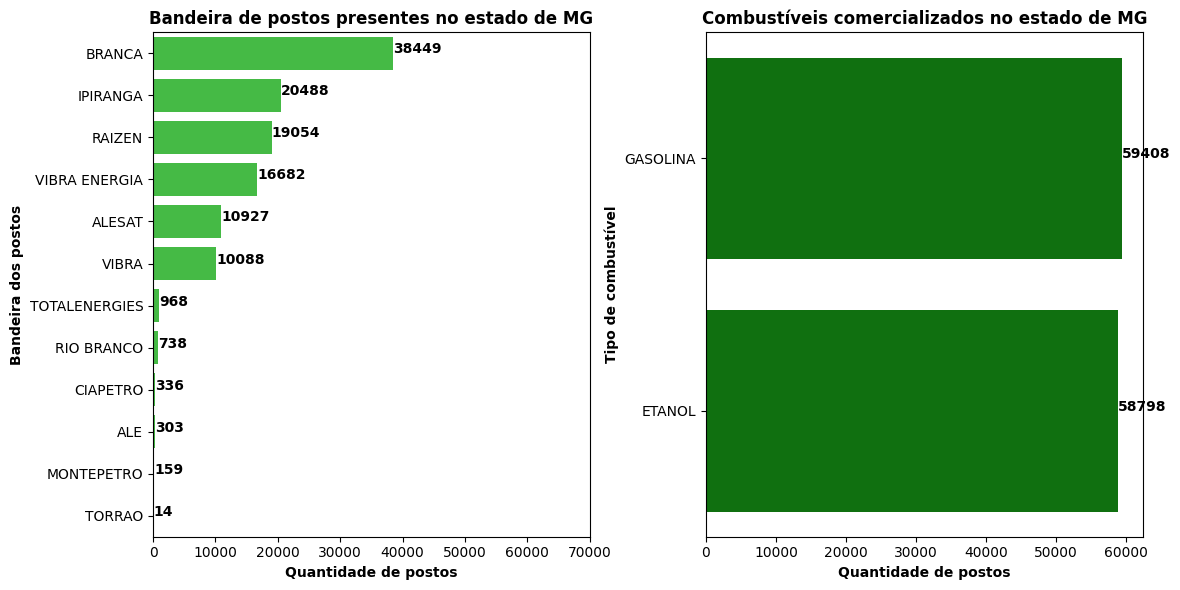

In [120]:
# BARPLOTS
## CRIANDO SUBPLOTS
fig, axs = plt.subplots(1, 2, figsize=(12,6))
plt.subplots_adjust(wspace=2)

#------------------------------------------------------------------------------------#
### PLT1
counts = df_fuels['bandeira'].value_counts().sort_values(ascending=False)
sns.barplot(data=counts, orient='h', color='limegreen', ax=axs[0])
for index, val in enumerate(counts.values):
    axs[0].text(val, index, str(val), fontweight='bold')

axs[0].set_xlim(right=70000)
axs[0].set_title('Bandeira de postos presentes no estado de MG', fontweight='bold')
axs[0].set_ylabel('Bandeira dos postos', fontweight='bold')
axs[0].set_xlabel('Quantidade de postos', fontweight='bold')

#------------------------------------------------------------------------------------#
### PLT2
counts2 = df_fuels['tipo_comb'].value_counts().sort_values(ascending=False)
sns.barplot(data=counts2, orient='h', color='green', ax=axs[1])
for index, val in enumerate(counts2.values):
    axs[1].text(val, index, str(val), fontweight='bold')


axs[1].set_title('Combustíveis comercializados no estado de MG', fontweight='bold')
axs[1].set_ylabel('Tipo de combustível', fontweight='bold')
axs[1].set_xlabel('Quantidade de postos', fontweight='bold')

#------------------------------------------------------------------------------------#
## PLOT COMPLETO
plt.tight_layout()
plt.show()

### **MAPPLOT**

In [94]:
# CRIANDO DATAFRAMES PARA PLOT DO MAPA
## CONTAGEM DE MUNICIPIOS
counts_mun = df_fuels['municipio'].value_counts().sort_values(ascending=False)
df_mun = counts_mun.reset_index()

#------------------------------------------------------------------------------------#
## GEODATAFRAMES PARA MAPA
mg_state = gpd.read_file('br_mg.json')
mg_mun = gpd.read_file('geojson_mun_mg.json')
mg_mun.drop(['id', 'description'], axis=1, inplace=True)

### REMOVENDO CARACTERES PARA FACILITAR O MERGE
def rem_pontuacao(pontuation):
    norm = unicodedata.normalize('NFKD', pontuation)
    removed = norm.encode('ascii', 'ignore').decode('ascii')
    return removed

mg_mun['name'] = mg_mun['name'].str.upper()
mg_mun['name'] = mg_mun['name'].apply(rem_pontuacao)

#------------------------------------------------------------------------------------#
## DATAFRAME FINAL PARA PLOT
geo_mg = mg_mun.set_index('name').join(df_mun.set_index('municipio'))
geo_mg['count'] = geo_mg['count'].fillna(0)

### TOP 5 MUNICIPIOS POR QUANTIDADE
top_10 = geo_mg.sort_values(by='count', ascending=False).head(5).reset_index()

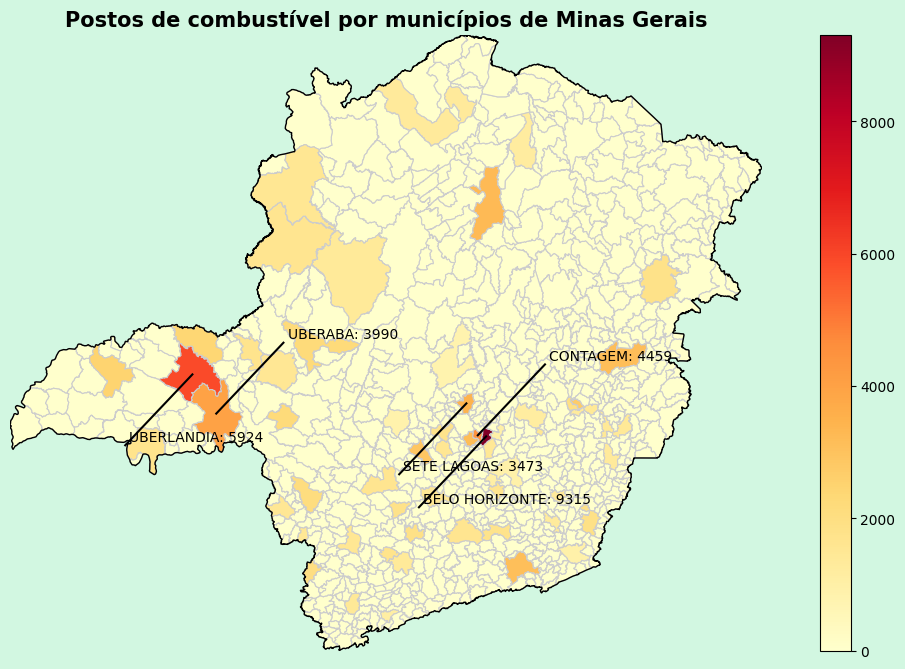

In [96]:
# MAPPLOT
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.patch.set_facecolor('#d2f7e1')
mg_state.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
geo_mg.plot(column='count', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

#------------------------------------------------------------------------------------#
## LEGENDA DOS TOP5 ESTADOS
for i, j in top_10.iterrows():
    centro = j['geometry'].centroid
    
    z = random.choice([-1, 1])
    offset_x, offset_y = 1*z, 1*z

    line_end = (centro.x + offset_x, centro.y + offset_y)
    
    ax.plot([centro.x, line_end[0]], [centro.y, line_end[1]], color='black')
    ax.annotate(f"{j['name']}: {j['count']}", xy=line_end, xytext=(3, 3), textcoords="offset points", ha='left')
    
#------------------------------------------------------------------------------------#
## CONFIGURAÇÕES GERAIS
ax.margins(0)
ax.set_axis_off()
ax.set_title('Postos de combustível por municípios de Minas Gerais', fontsize=15, fontweight='bold')

plt.show()

### **DIST PLOTS**

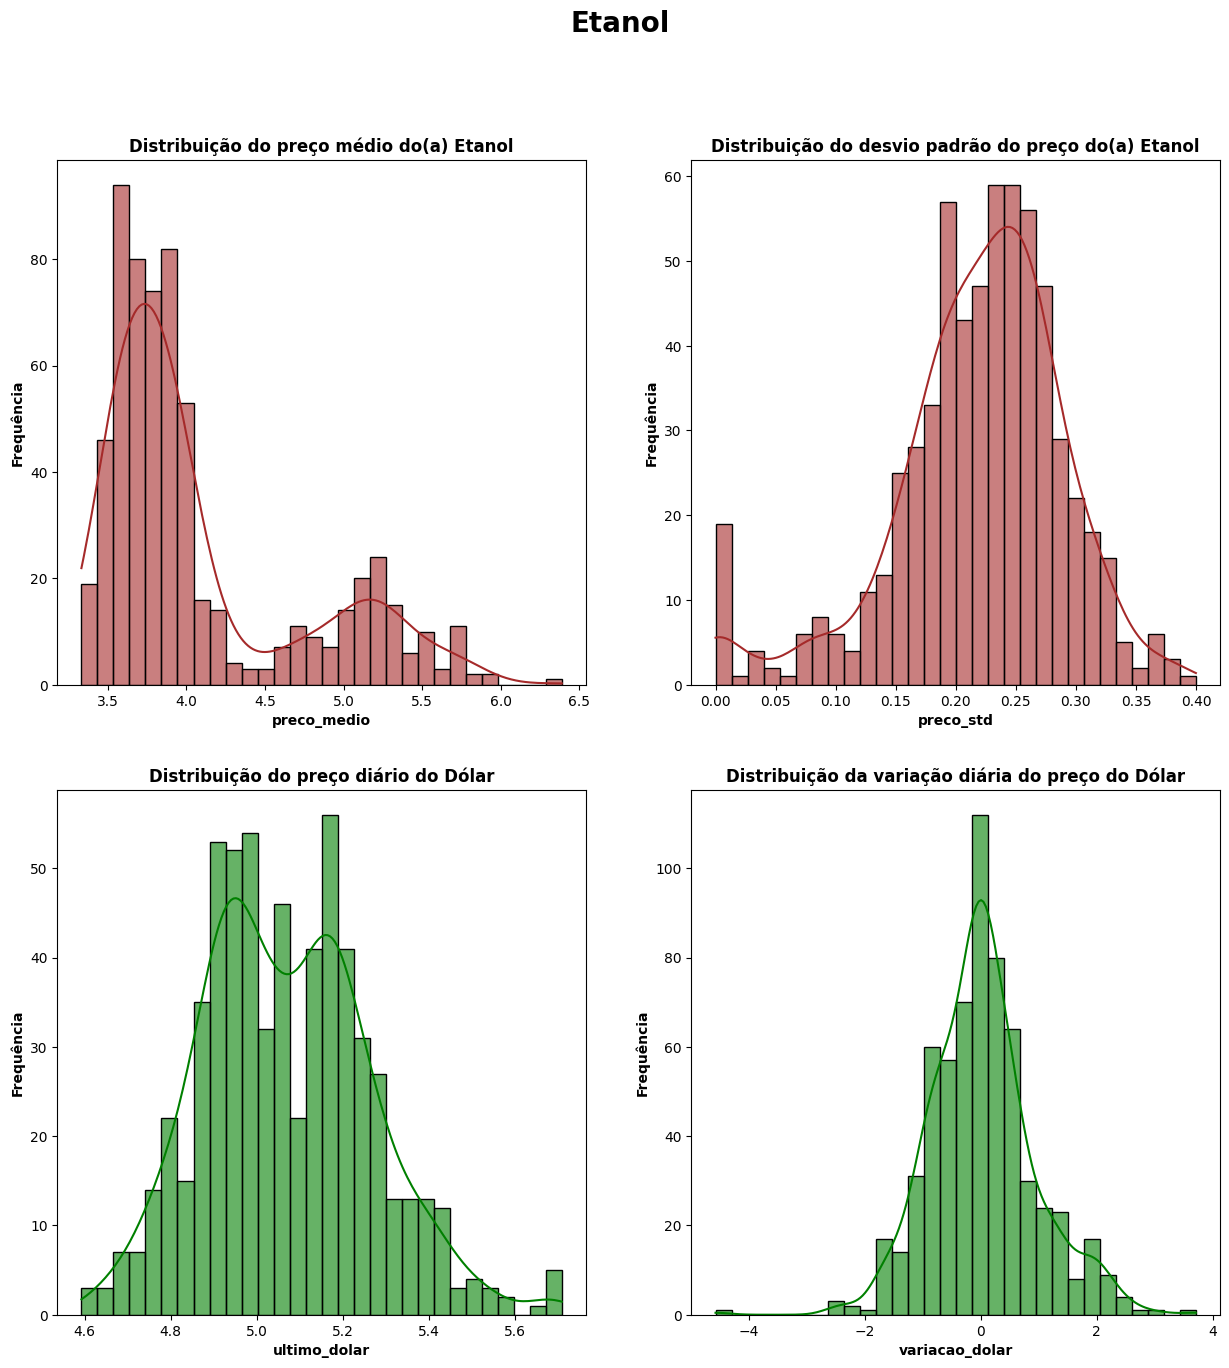

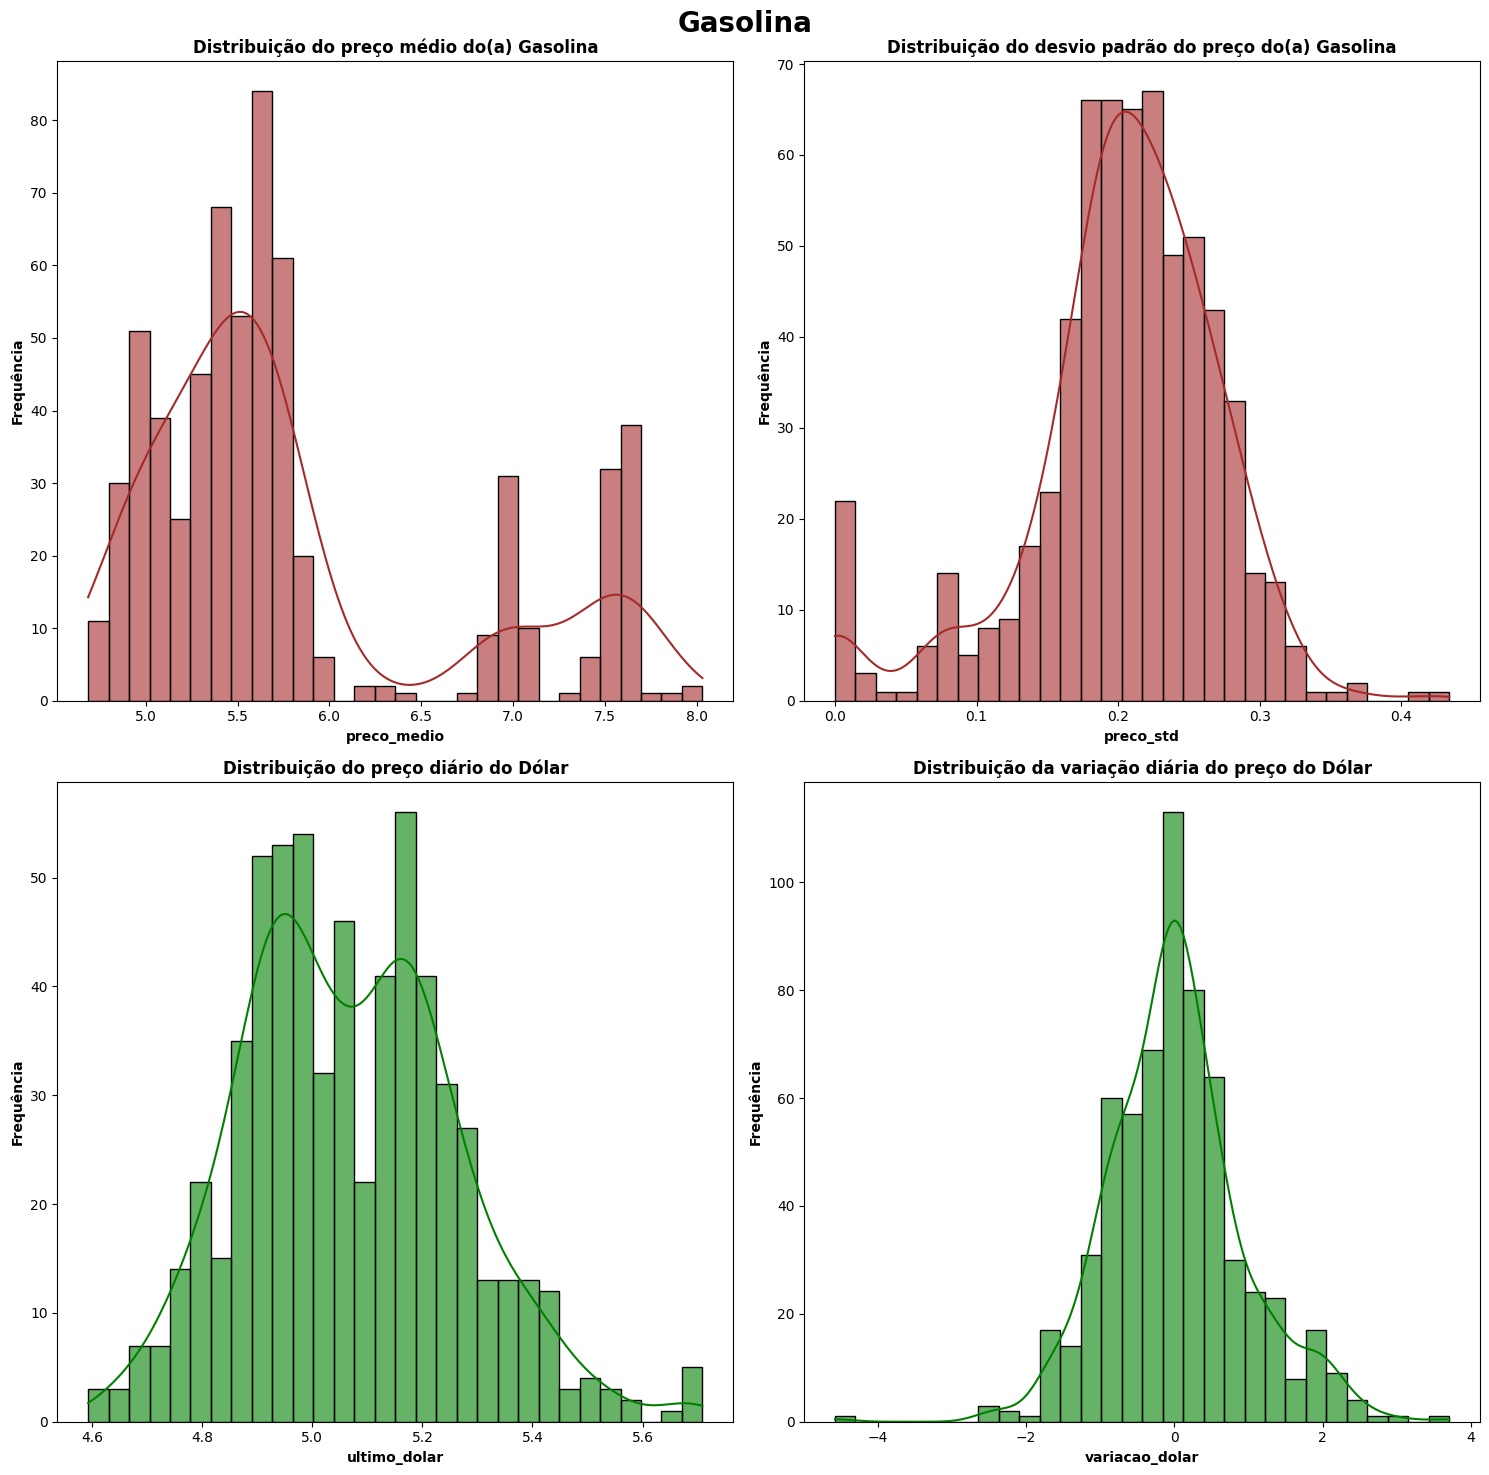

In [19]:
for df in dfs:
    nome = df.split('_')[1].capitalize()
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    fig.suptitle(f'{nome}', fontweight='bold', fontsize='20')
    
    sns.histplot(dfs[df]['preco_medio'], bins=30, kde=True, color='brown', edgecolor='k', alpha=0.6, ax=ax[0,0])
    sns.histplot(dfs[df]['preco_std'], bins=30, kde=True, color='brown', edgecolor='k', alpha=0.6, ax=ax[0,1])
    sns.histplot(dfs[df]['ultimo_dolar'], bins=30, kde=True, color='green', edgecolor='k', alpha=0.6, ax=ax[1,0])
    sns.histplot(dfs[df]['variacao_dolar'], bins=30, kde=True, color='green', edgecolor='k', alpha=0.6, ax=ax[1,1])
    ax[0,0].set_title(f'Distribuição do preço médio do(a) {nome}', fontweight='bold')
    ax[0,1].set_title(f'Distribuição do desvio padrão do preço do(a) {nome}', fontweight='bold')
    ax[1,0].set_title('Distribuição do preço diário do Dólar', fontweight='bold')
    ax[1,1].set_title('Distribuição da variação diária do preço do Dólar', fontweight='bold')
    for axis in ax:
        for k in axis:
            k.set_ylabel('Frequência', fontweight='bold')
            k.set_xlabel(k.get_xlabel(), fontweight='bold')
        

plt.tight_layout()
plt.show()

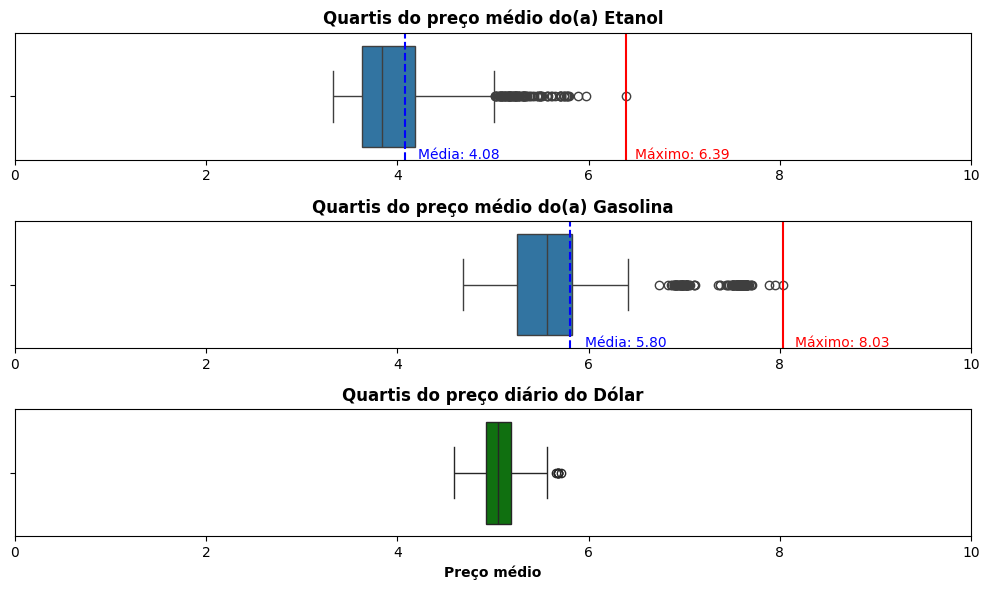

In [23]:
fig, ax = plt.subplots(3,1, figsize=(10,6))
i=0
for df in dfs:
    nome = df.split('_')[1].capitalize()
    mn = dfs[df]['preco_medio'].mean()
    mx = dfs[df]['preco_medio'].max()
    sns.boxplot(x=dfs[df]['preco_medio'], ax=ax[i])
    ax[i].set_title(f'Quartis do preço médio do(a) {nome}', fontweight='bold')
    ax[i].set_xlabel('')
    ax[i].set_xlim((0,10))
    ax[i].axvline(mn, color='blue', linestyle='--', label='Média')
    ax[i].axvline(mx, color='red', linestyle='-', label='Máximo')
    ax[i].annotate(f'Média: {mn:.2f}', xy=(mn+0.5, 0.5), xytext=(mn, 0.5),
               textcoords='offset points', ha='center', color='blue')
    ax[i].annotate(f'Máximo: {mx:.2f}', xy=(mx+0.5, 0.5), xytext=(mx, 0.5),
               textcoords='offset points', ha='center', color='red')
    i += 1

sns.boxplot(x=dfs['df_etanol']['ultimo_dolar'], color='green', ax=ax[i])
ax[i].set_title('Quartis do preço diário do Dólar', fontweight='bold')
ax[i].set_xlabel('Preço médio', fontweight='bold')
ax[i].set_xlim((0,10))

plt.tight_layout()
plt.show()

### **TIME SERIES PLOTS**

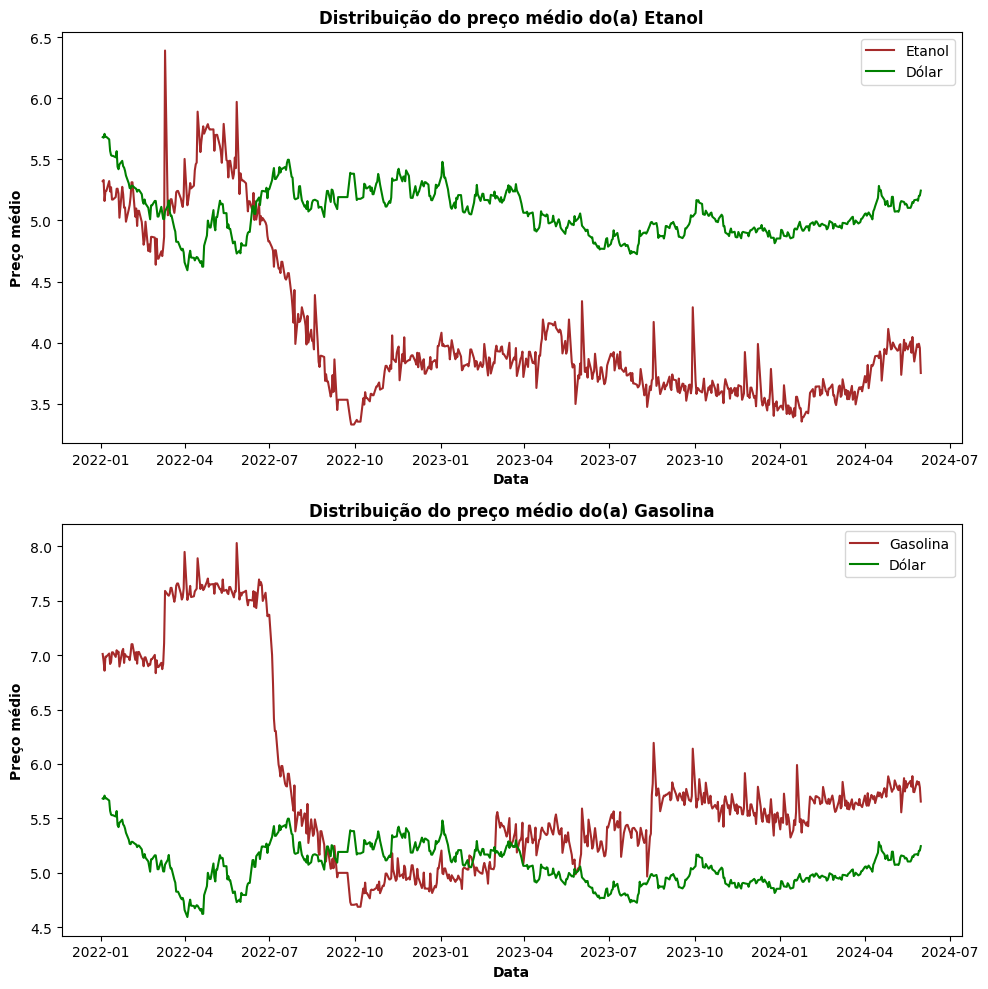

In [47]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
i=0
for df in dfs:
    nome = df.split('_')[1].capitalize()    
    sns.lineplot(x=dfs[df]['data'], y=dfs[df]['preco_medio'], label=f'{nome}', color='brown', ax=ax[i])
    sns.lineplot(x=dfs[df]['data'], y=dfs[df]['ultimo_dolar'], label='Dólar', color='green', ax=ax[i])
    ax[i].set_title(f'Distribuição do preço médio do(a) {nome}', fontweight='bold')
    ax[i].set_xlabel('Data', fontweight='bold')
    ax[i].set_ylabel('Preço médio', fontweight='bold')
    ax[i].legend()
    i += 1

plt.tight_layout()
plt.show()

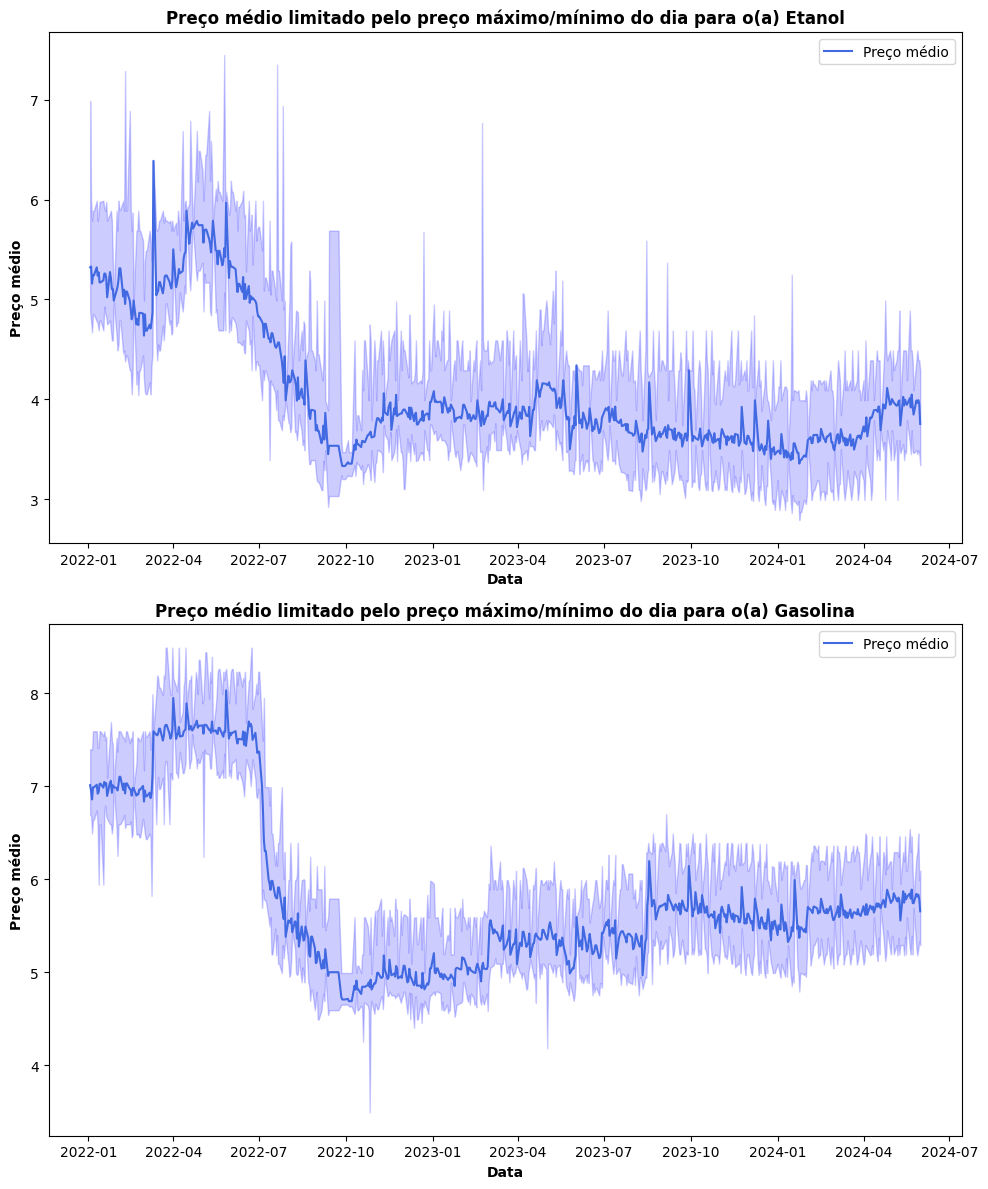

In [60]:
fig, ax = plt.subplots(2,1, figsize=(10,12))
i=0
for df in dfs:
    nome = df.split('_')[1].capitalize()
    #upper = dfs[df]['preco_medio'] + dfs[df]['preco_std']
    #lower = dfs[df]['preco_medio'] - dfs[df]['preco_std']
    upper=dfs[df]['preco_max']
    lower=dfs[df]['preco_min']
    sns.lineplot(x=dfs[df]['data'], y=dfs[df]['preco_medio'], color='royalblue', label='Preço médio', ax=ax[i])
    ax[i].fill_between(dfs[df]['data'], lower, upper, color='blue', alpha=0.2)
    ax[i].set_title(f'Preço médio limitado pelo preço máximo/mínimo do dia para o(a) {nome}', fontweight='bold')
    ax[i].set_xlabel('Data', fontweight='bold')
    ax[i].set_ylabel('Preço médio', fontweight='bold')
    i += 1

plt.tight_layout()
plt.show()

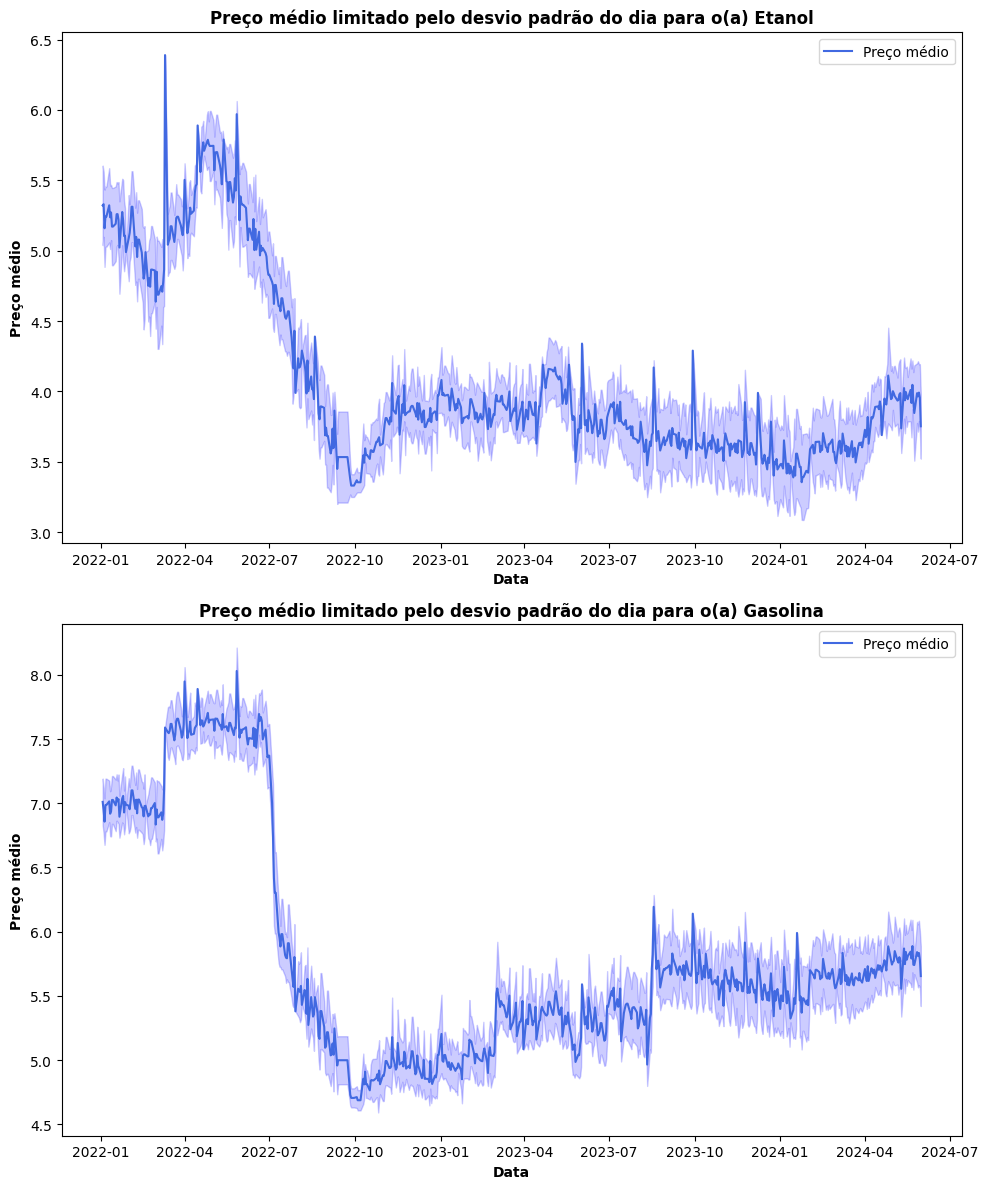

In [62]:
fig, ax = plt.subplots(2,1, figsize=(10,12))
i=0
for df in dfs:
    nome = df.split('_')[1].capitalize()
    upper = dfs[df]['preco_medio'] + dfs[df]['preco_std']
    lower = dfs[df]['preco_medio'] - dfs[df]['preco_std']
    sns.lineplot(x=dfs[df]['data'], y=dfs[df]['preco_medio'], color='royalblue', label='Preço médio', ax=ax[i])
    ax[i].fill_between(dfs[df]['data'], lower, upper, color='blue', alpha=0.2)
    ax[i].set_title(f'Preço médio limitado pelo desvio padrão do dia para o(a) {nome}', fontweight='bold')
    ax[i].set_xlabel('Data', fontweight='bold')
    ax[i].set_ylabel('Preço médio', fontweight='bold')
    i += 1

plt.tight_layout()
plt.show()

### **HEATMAP/CORRELATION PLOTS**

In [143]:
## PREPARANDO DADOS PARA HEATMAP
etanol_heat = dfs['df_etanol'].copy()
gasolina_heat = dfs['df_gasolina'].copy()

dfs_heat = [etanol_heat, gasolina_heat]

for i, df in enumerate(dfs_heat):
    df['year'] = df['data'].dt.year
    df['month'] = df['data'].dt.month
    df = df.groupby(['year', 'month'])['preco_medio'].mean().reset_index()
    df = df.pivot_table(index='year', columns='month', values='preco_medio')
    dfs_heat[i] = df

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
i=0
for df in dfs_heat:
    sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5, ax=ax[i])
    ax[i].set_xlabel('Mês', fontweight='bold')
    ax[i].set_ylabel('Ano', fontweight='bold')
    ax[i].xaxis.tick_top()
    ax[i].xaxis.set_label_position('top')
    i += 1

ax[0].set_title(f'Mapa de calor do preço médio do Etanol', fontweight='bold', fontsize=20, pad=30)
ax[1].set_title(f'Mapa de calor do preço médio da Gasolina', fontweight='bold', fontsize=20, pad=30)

plt.tight_layout()
plt.show()

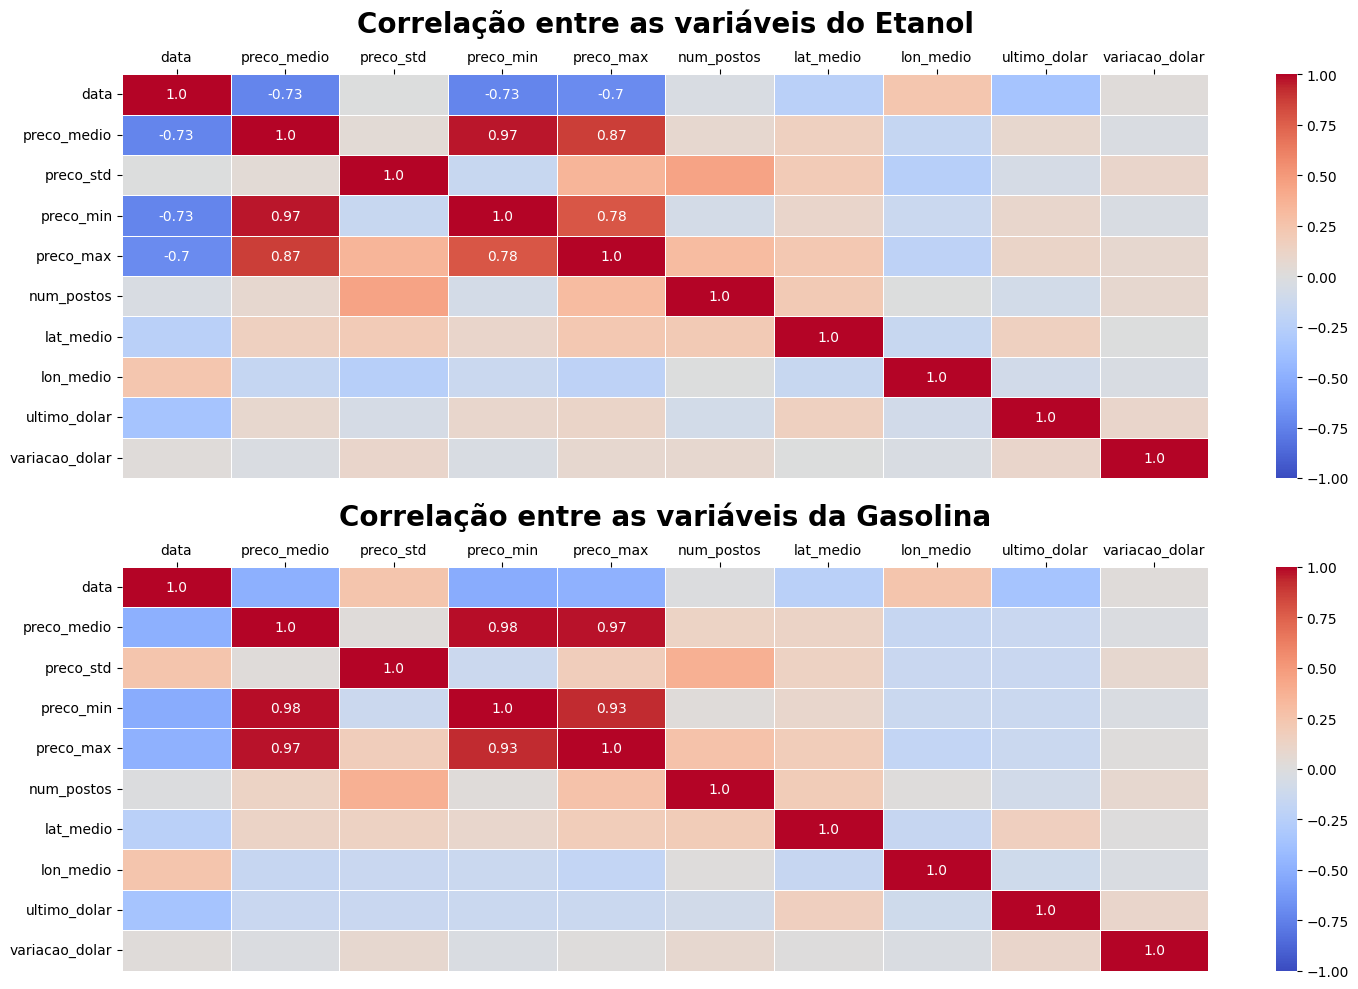

In [7]:
## OBTENDO AS MATRIZES DE CORRELAÇÃO
corr_etanol = df_etanol.drop(columns='tipo_comb').corr()
corr_gasolina = df_gasolina.drop(columns='tipo_comb').corr()
matrixes = [corr_etanol, corr_gasolina]

### GRÁFICO DE CORRELAÇÃO ENTRE AS VARIÁVEIS
fig, ax = plt.subplots(2,1, figsize=(15,10))
i=0
for df in matrixes:
    high_corr = np.where((df >= 0.7) | (df <= -0.7), df.round(2).astype(str), '')
    sns.heatmap(df, annot=high_corr, cmap='coolwarm', fmt='', vmin=-1, vmax=1, center=0, linewidth=0.5, ax=ax[i])
    ax[i].xaxis.tick_top()
    i += 1

ax[0].set_title(f'Correlação entre as variáveis do Etanol', fontweight='bold', fontsize=20, pad=30)
ax[1].set_title(f'Correlação entre as variáveis da Gasolina', fontweight='bold', fontsize=20, pad=30)

plt.tight_layout()
plt.show()

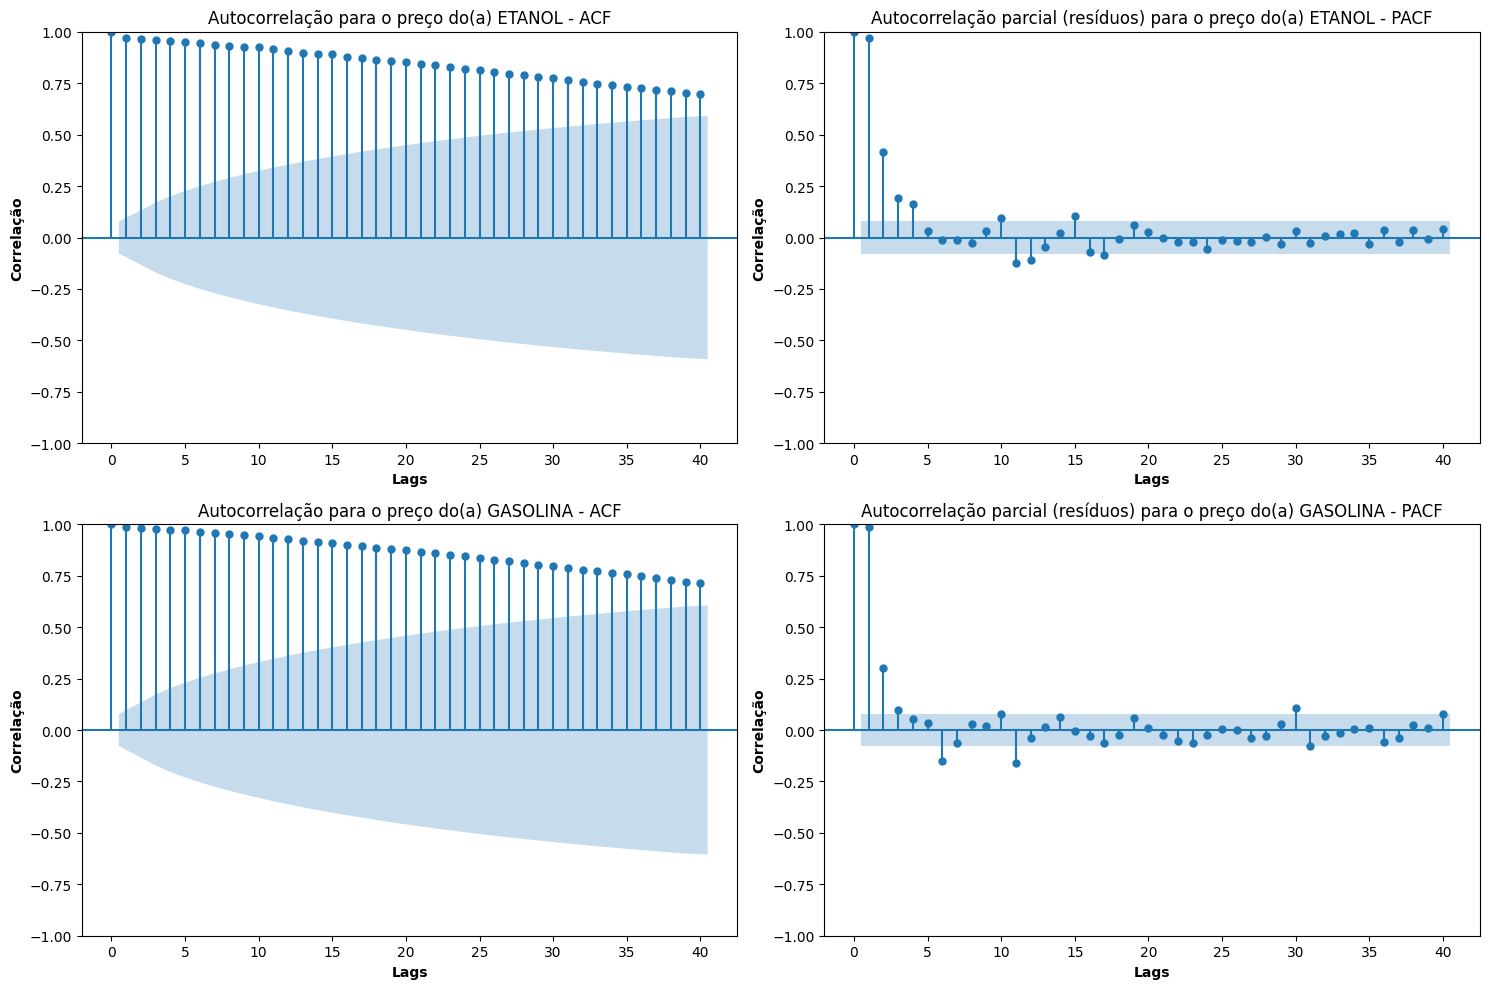

In [99]:
### GRÁFICO DE AUTOCORRELAÇÃO E RESÍDUOS (PACF E ACF)
dfs = [df_etanol, df_gasolina]

fig, ax = plt.subplots(2,2, figsize=(15,10))
i=0
for df in dfs:
    plot_acf(df['preco_medio'], lags=40, ax=ax[i,0])
    plot_pacf(df['preco_medio'], lags=40, ax=ax[i,1])
    ax[i,0].set_title(f'Autocorrelação para o preço do(a) {df['tipo_comb'].iloc[0]} - ACF')
    ax[i,0].set_xlabel('Lags', fontweight='bold')
    ax[i,0].set_ylabel('Correlação', fontweight='bold')

    ax[i,1].set_title(f'Autocorrelação parcial (resíduos) para o preço do(a) {df['tipo_comb'].iloc[0]} - PACF')
    ax[i,1].set_xlabel('Lags', fontweight='bold')
    ax[i,1].set_ylabel('Correlação', fontweight='bold')
    i += 1

plt.tight_layout()
plt.show()

In [3]:
indexed_etanol = df_etanol.set_index('data')
indexed_gas = df_gasolina.set_index('data')
sd_etanol = seasonal_decompose(indexed_etanol['preco_medio'], model='additive', period=30)
sd_gas = seasonal_decompose(indexed_gas['preco_medio'], model='additive', period=30)

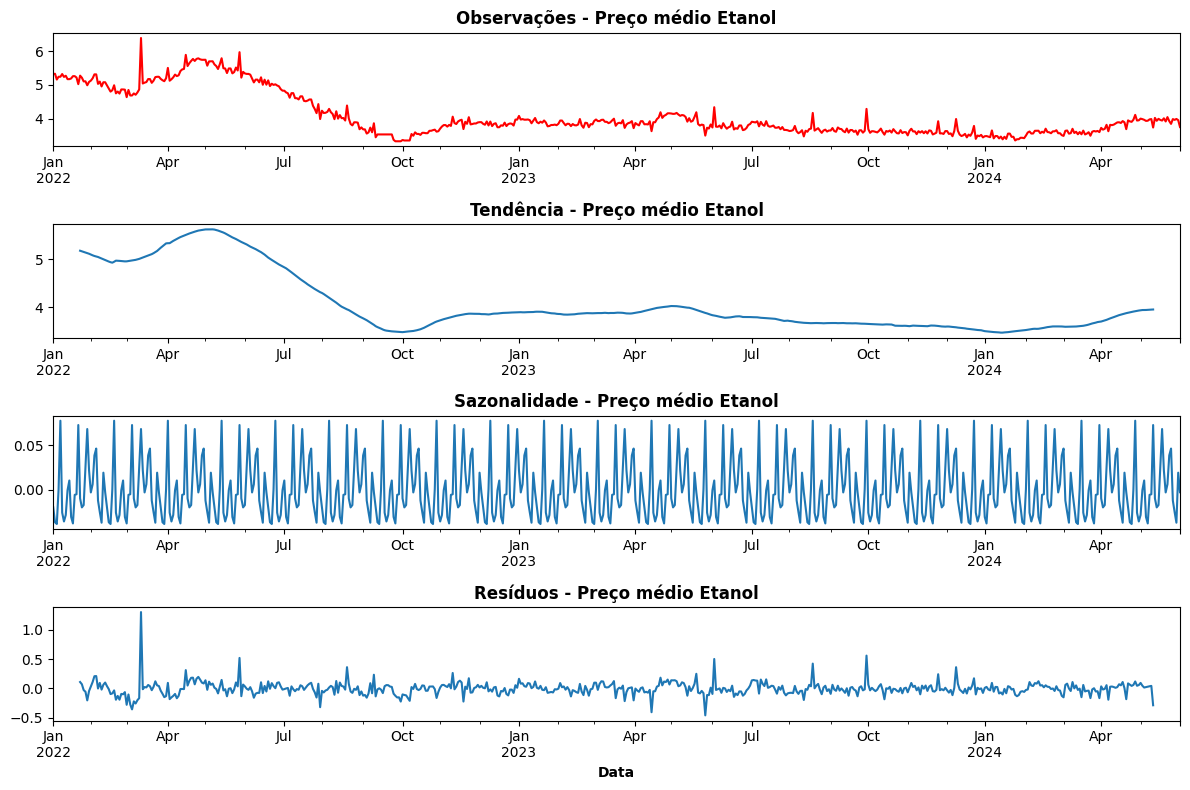

In [130]:
### SEASONAL DECOMPOSE SÉRIE ETANOL
fig, ax = plt.subplots(4,1, figsize=(12,8))

sd_etanol.observed.plot(ax=ax[0], color='red')
ax[0].set_title('Observações - Preço médio Etanol', fontweight='bold')
ax[0].set_xlabel('')

sd_etanol.trend.plot(ax=ax[1])
ax[1].set_title('Tendência - Preço médio Etanol', fontweight='bold')
ax[1].set_xlabel('')

sd_etanol.seasonal.plot(ax=ax[2])
ax[2].set_title('Sazonalidade - Preço médio Etanol', fontweight='bold')
ax[2].set_xlabel('')

sd_etanol.resid.plot(ax=ax[3])
ax[3].set_title('Resíduos - Preço médio Etanol', fontweight='bold')
ax[3].set_xlabel('Data', fontweight='bold')


plt.tight_layout()
plt.show()

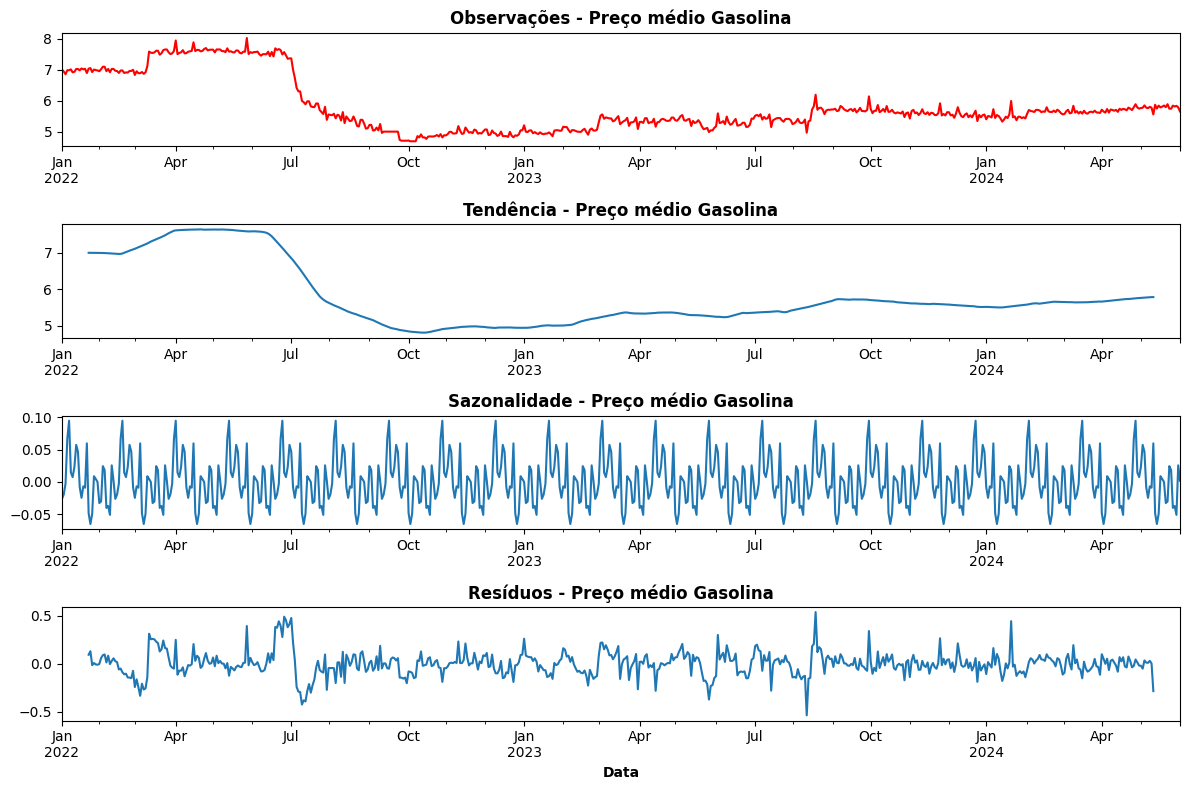

In [4]:
### SEASONAL DECOMPOSE SÉRIE GASOLINA
fig, ax = plt.subplots(4,1, figsize=(12,8))

sd_gas.observed.plot(ax=ax[0], color='red')
ax[0].set_title('Observações - Preço médio Gasolina', fontweight='bold')
ax[0].set_xlabel('')

sd_gas.trend.plot(ax=ax[1])
ax[1].set_title('Tendência - Preço médio Gasolina', fontweight='bold')
ax[1].set_xlabel('')

sd_gas.seasonal.plot(ax=ax[2])
ax[2].set_title('Sazonalidade - Preço médio Gasolina', fontweight='bold')
ax[2].set_xlabel('')

sd_gas.resid.plot(ax=ax[3])
ax[3].set_title('Resíduos - Preço médio Gasolina', fontweight='bold')
ax[3].set_xlabel('Data', fontweight='bold')


plt.tight_layout()
plt.show()

## **Salvar/Carregar Datasets Finais**

In [ ]:
### Salvando Datasets para modelagem
dfs['df_etanol'].to_csv(r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Datasets\df_etanol_final.csv', index=False)
dfs['df_gasolina'].to_csv(r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Datasets\df_gasolina_final.csv', index=False)

In [2]:
### Carregando datasets da modelagem (RODAR PARA REFAZER ALGUMA EDA/PREPROCS)
df_etanol = pd.read_csv(r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes\df_etanol_final.csv')
df_gasolina = pd.read_csv(r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes\df_gasolina_final.csv')

df_etanol['data'] = pd.to_datetime(df_etanol['data'])
df_etanol['tipo_comb'] = df_etanol['tipo_comb'].astype('string')

df_gasolina['data'] = pd.to_datetime(df_gasolina['data'])
df_gasolina['tipo_comb'] = df_gasolina['tipo_comb'].astype('string')